In [1]:
import Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate();

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [37]:
using JuMP
using DisjunctiveProgramming
using ToQUBO
using DisjunctiveToQUBO
using DWave

In [65]:
include("paper.jl");

$$
\begin{array}{rll}
\displaystyle \max_{x, y} & x - y \\
            \textrm{s.t.} & \left[
                                \begin{array}{c}
                                    Y_1 \\
                                    -2 \leq x \leq -1 \\
                                    -2 \leq y \leq -1
                                \end{array}
                            \right] \bigvee
                            \left[
                                \begin{array}{c}
                                    Y_2 \\
                                    1 \leq x \leq 2 \\
                                    1 \leq y \leq 2
                                \end{array}
                            \right] \\[1.5em]
                        ~ & -2 \leq x, y \leq 2  \\
                        ~ & Y_{1}, Y_{2} \in \{ \textrm{True}, \textrm{False} \}
\end{array}
$$

In [68]:
function build_model(config!::Function, optimizer)
    model = GDPModel(() -> ToQUBO.Optimizer(optimizer))

    @variable(model, -2 <= x <= 2)
    @variable(model, -2 <= y <= 2)

    @variable(model, Y[1:2], Logical)

    @objective(model, Max, x - y)

    @constraint(model, -2 .≤ [x, y] .≤ -1, Disjunct.([Y[1], Y[1]]))
    @constraint(model, 1 .≤ [x, y] .≤ 2, Disjunct.([Y[2], Y[2]]))

    disjunction(model, Y, exactly1 = true)

    config!(model)

    return model
end

function run_model(config!::Function, optimizer = nothing; method = Indicator())
    model = build_model(config!, optimizer)

    optimize!(model; gdp_method=method)

    return model
end

run_model(optimzer = nothing; method = Indicator()) = run_model(identity, optimizer; method)

run_model (generic function with 4 methods)

In [4]:
using Plots

# Make plots look professional
Plots.default(;
    fontfamily = "Computer Modern",
    plot_titlefontsize  = 16,
    titlefontsize       = 14,
    guidefontsize       = 12,
    legendfontsize      = 10,
    tickfontsize        = 10,
)

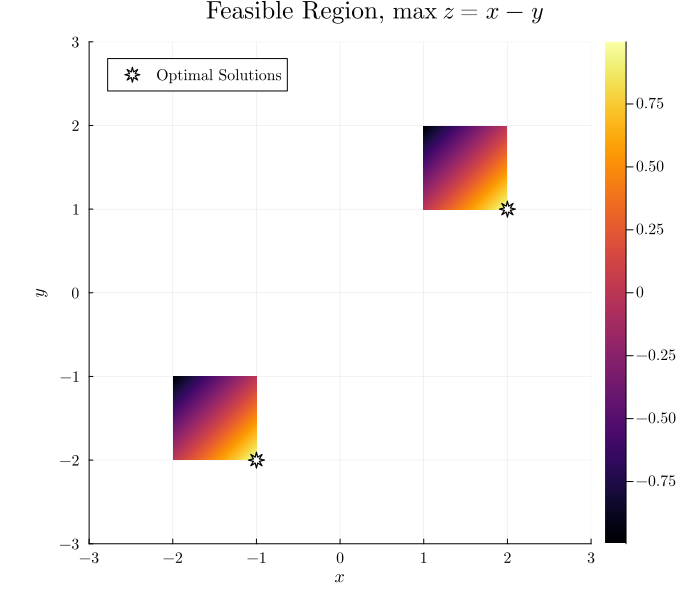

In [53]:
function feasible_region(; ns::Integer = 1_000)
    x = y = range(-3, 3; length = ns)

    objective(x, y) = x - y

    feasible(x, y) = (-2 ≤ x ≤ -1 && -2 ≤ y ≤ -1) || (1 ≤ x ≤ 2 && 1 ≤ y ≤ 2)
    coloring(x, y) = ifelse(feasible(x, y), objective(x, y), NaN)

    plt = plot(;
        size         = (700, 600),
        plot_title   = raw"Feasible Region, $ \max~z = x - y $",
        xlabel       = "x",
        ylabel       = "y",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        aspect_ratio = :equal,
    )

    heatmap!(
        plt, x, y, coloring;
        legend = :topleft,
        xlims  = extrema(x),
        ylims  = extrema(y),
        xlabel = raw"$ x $",
        ylabel = raw"$ y $",
    )

    scatter!(
        plt,
        [-1, 2],
        [-2, 1];
        color  = :white,
        marker = :star8,
        markersize = 8,
        label  = "Optimal Solutions",
    )

    plt
end

feasible_region()

# Big-M Reformulation

In [80]:
model = run_model(DWave.Neal.Optimizer, method = BigM(3.5, false)) do m
    set_attribute(m, "num_reads", 2_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.([m[:x], m[:y]], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Arithmetic())
end

compilation_summary(model)
solution_summary(model)
sampling_summary(model, 1.0)

value(model[:x]; result=1), value(model[:y]; result=1)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 52
  Encoding ………………… 8
  Slack ………………………… 44
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.21342383107088989

⋄ Coefficient Range
  Lower Bound ………… -6912.0
  Upper Bound ………… 20421.0

⋄ Constant Offset: -57681.0

⋄ Work counters
  Compiltaion Time (sec) : 0.00031637
⋄ Sampling Summary

⋄ Number of samples: 1855

⋄ Best energy: 0.6666666666678793

⋄ Time-to-target (sec): -Inf


(-1.3333333333333335, -2.0)

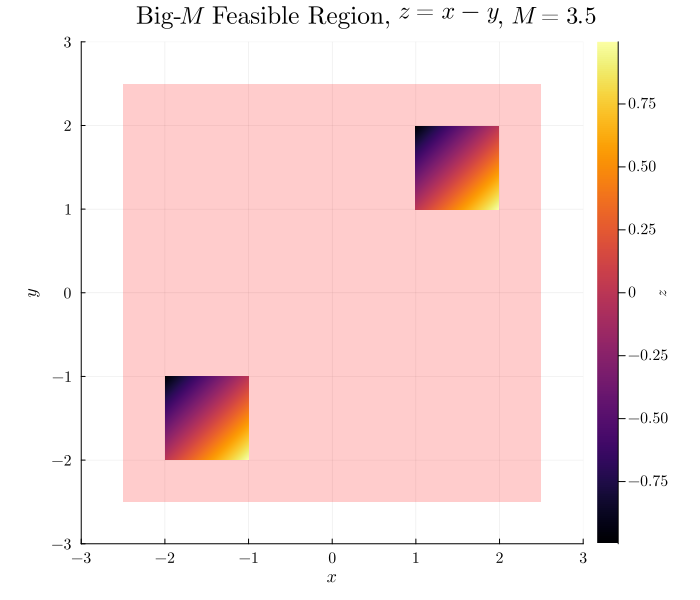

In [47]:
function bigm_region(M = 3.5; ns::Integer = 1_000)
    x = y = range(-3, 3; length = ns)

    objective(x, y) = x - y

    feasible(x, y) = (-2 ≤ x ≤ -1 && -2 ≤ y ≤ -1) || (1 ≤ x ≤ 2 && 1 ≤ y ≤ 2)
    coloring(x, y) = ifelse(feasible(x, y), objective(x, y), NaN)

    envelope(x, y, M = M) = (-2 - M <= x <= -1 + M) &&
                            (-2 - M <= y <= -1 + M) &&
                            (1 - M <= x <= 2 + M) &&
                            (1 - M <= y <= 2 + M)
    
    shading(x, y) = ifelse(envelope(x, y), 1.0, NaN)

    plt = plot(;
        size         = (700, 600),
        plot_title   = "Big-\$M\$ Feasible Region, \$z = x - y\$, \$M = $M\$",
        xlabel       = raw"$x$",
        ylabel       = raw"$y$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        aspect_ratio = :equal,
        colorbar_title = raw"$ z $",
    )

    heatmap!(
        plt, x, y, shading;
        color = :red,
        alpha = 0.2,
        xlims = extrema(x),
        ylims = extrema(y),
        label = raw"Big-$M$ Envelope",
        colorbar_entry = false,
    )

    heatmap!(
        plt, x, y, coloring;
        xlims = extrema(x),
        ylims = extrema(y),
    )

    plt
end

bigm_region()

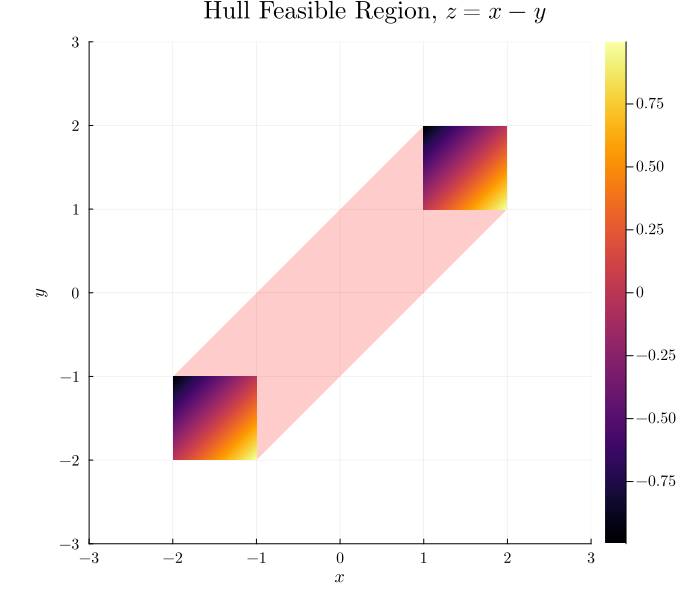

In [45]:
function hull_region(; ns::Integer = 1_000)
    x = y = range(-3, 3; length = ns)

    objective(x, y) = x - y

    feasible(x, y) = (-2 ≤ x ≤ -1 && -2 ≤ y ≤ -1) || (1 ≤ x ≤ 2 && 1 ≤ y ≤ 2)
    coloring(x, y) = ifelse(feasible(x, y), objective(x, y), NaN)

    envelope(x, y) = (-1 ≤ x - y ≤ 1) && (-2 ≤ x ≤ 2) && (-2 ≤ y ≤ 2) 
    
    shading(x, y) = ifelse(envelope(x, y), 1.0, NaN)

    plt = plot(;
        size         = (700, 600),
        plot_title   = raw"Hull Feasible Region, $ z = x - y $",
        xlabel       = raw"$x$",
        ylabel       = raw"$y$",
        xlims        = (-3, 3),
        ylims        = (-3, 3),
        aspect_ratio = :equal,
    )

    heatmap!(
        plt, x, y, shading;
        color  = :red,
        alpha  = 0.2,
        xlims  = extrema(x),
        ylims  = extrema(y),
        label  = "Hull Envelope",
        colorbar_entry = false,
    )

    heatmap!(
        plt, x, y, coloring;
        label  = false,
        xlims  = extrema(x),
        ylims  = extrema(y),
    )

    plt
end

hull_region()